In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply

In [14]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hz

In [15]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [54]:
# compute correlator
dt = 1e-2
n = 12
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
Cs = np.einsum('j, ij -> i', psi.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.266407934929788
Excited state energy: -19.52953059144967


In [27]:
import sys
#sys.path.append("/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job")
print(sys.path)

import os
print(os.getcwd())

import TCI_singlesite as TCI

['/Users/Giovanni/miniconda3/envs/Computational/lib/python312.zip', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/lib-dynload', '', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages']
/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job


### TCI for Cs.imag, Cs.real and Cs.abs separately
Here we build correlation function with TCI, and check after how many function evaluations we obtain the correct function

['Cs_abs', 'Cs_re', 'Cs_im']
[1.         0.99989822 0.99959292 ... 0.55302407 0.55652544 0.55994185]
[ 1.          0.99920017  0.99680264 ... -0.27387565 -0.26039289
 -0.2464291 ]
[ 0.         -0.03735605 -0.07463581 ...  0.48044537  0.49184968
  0.50279973]


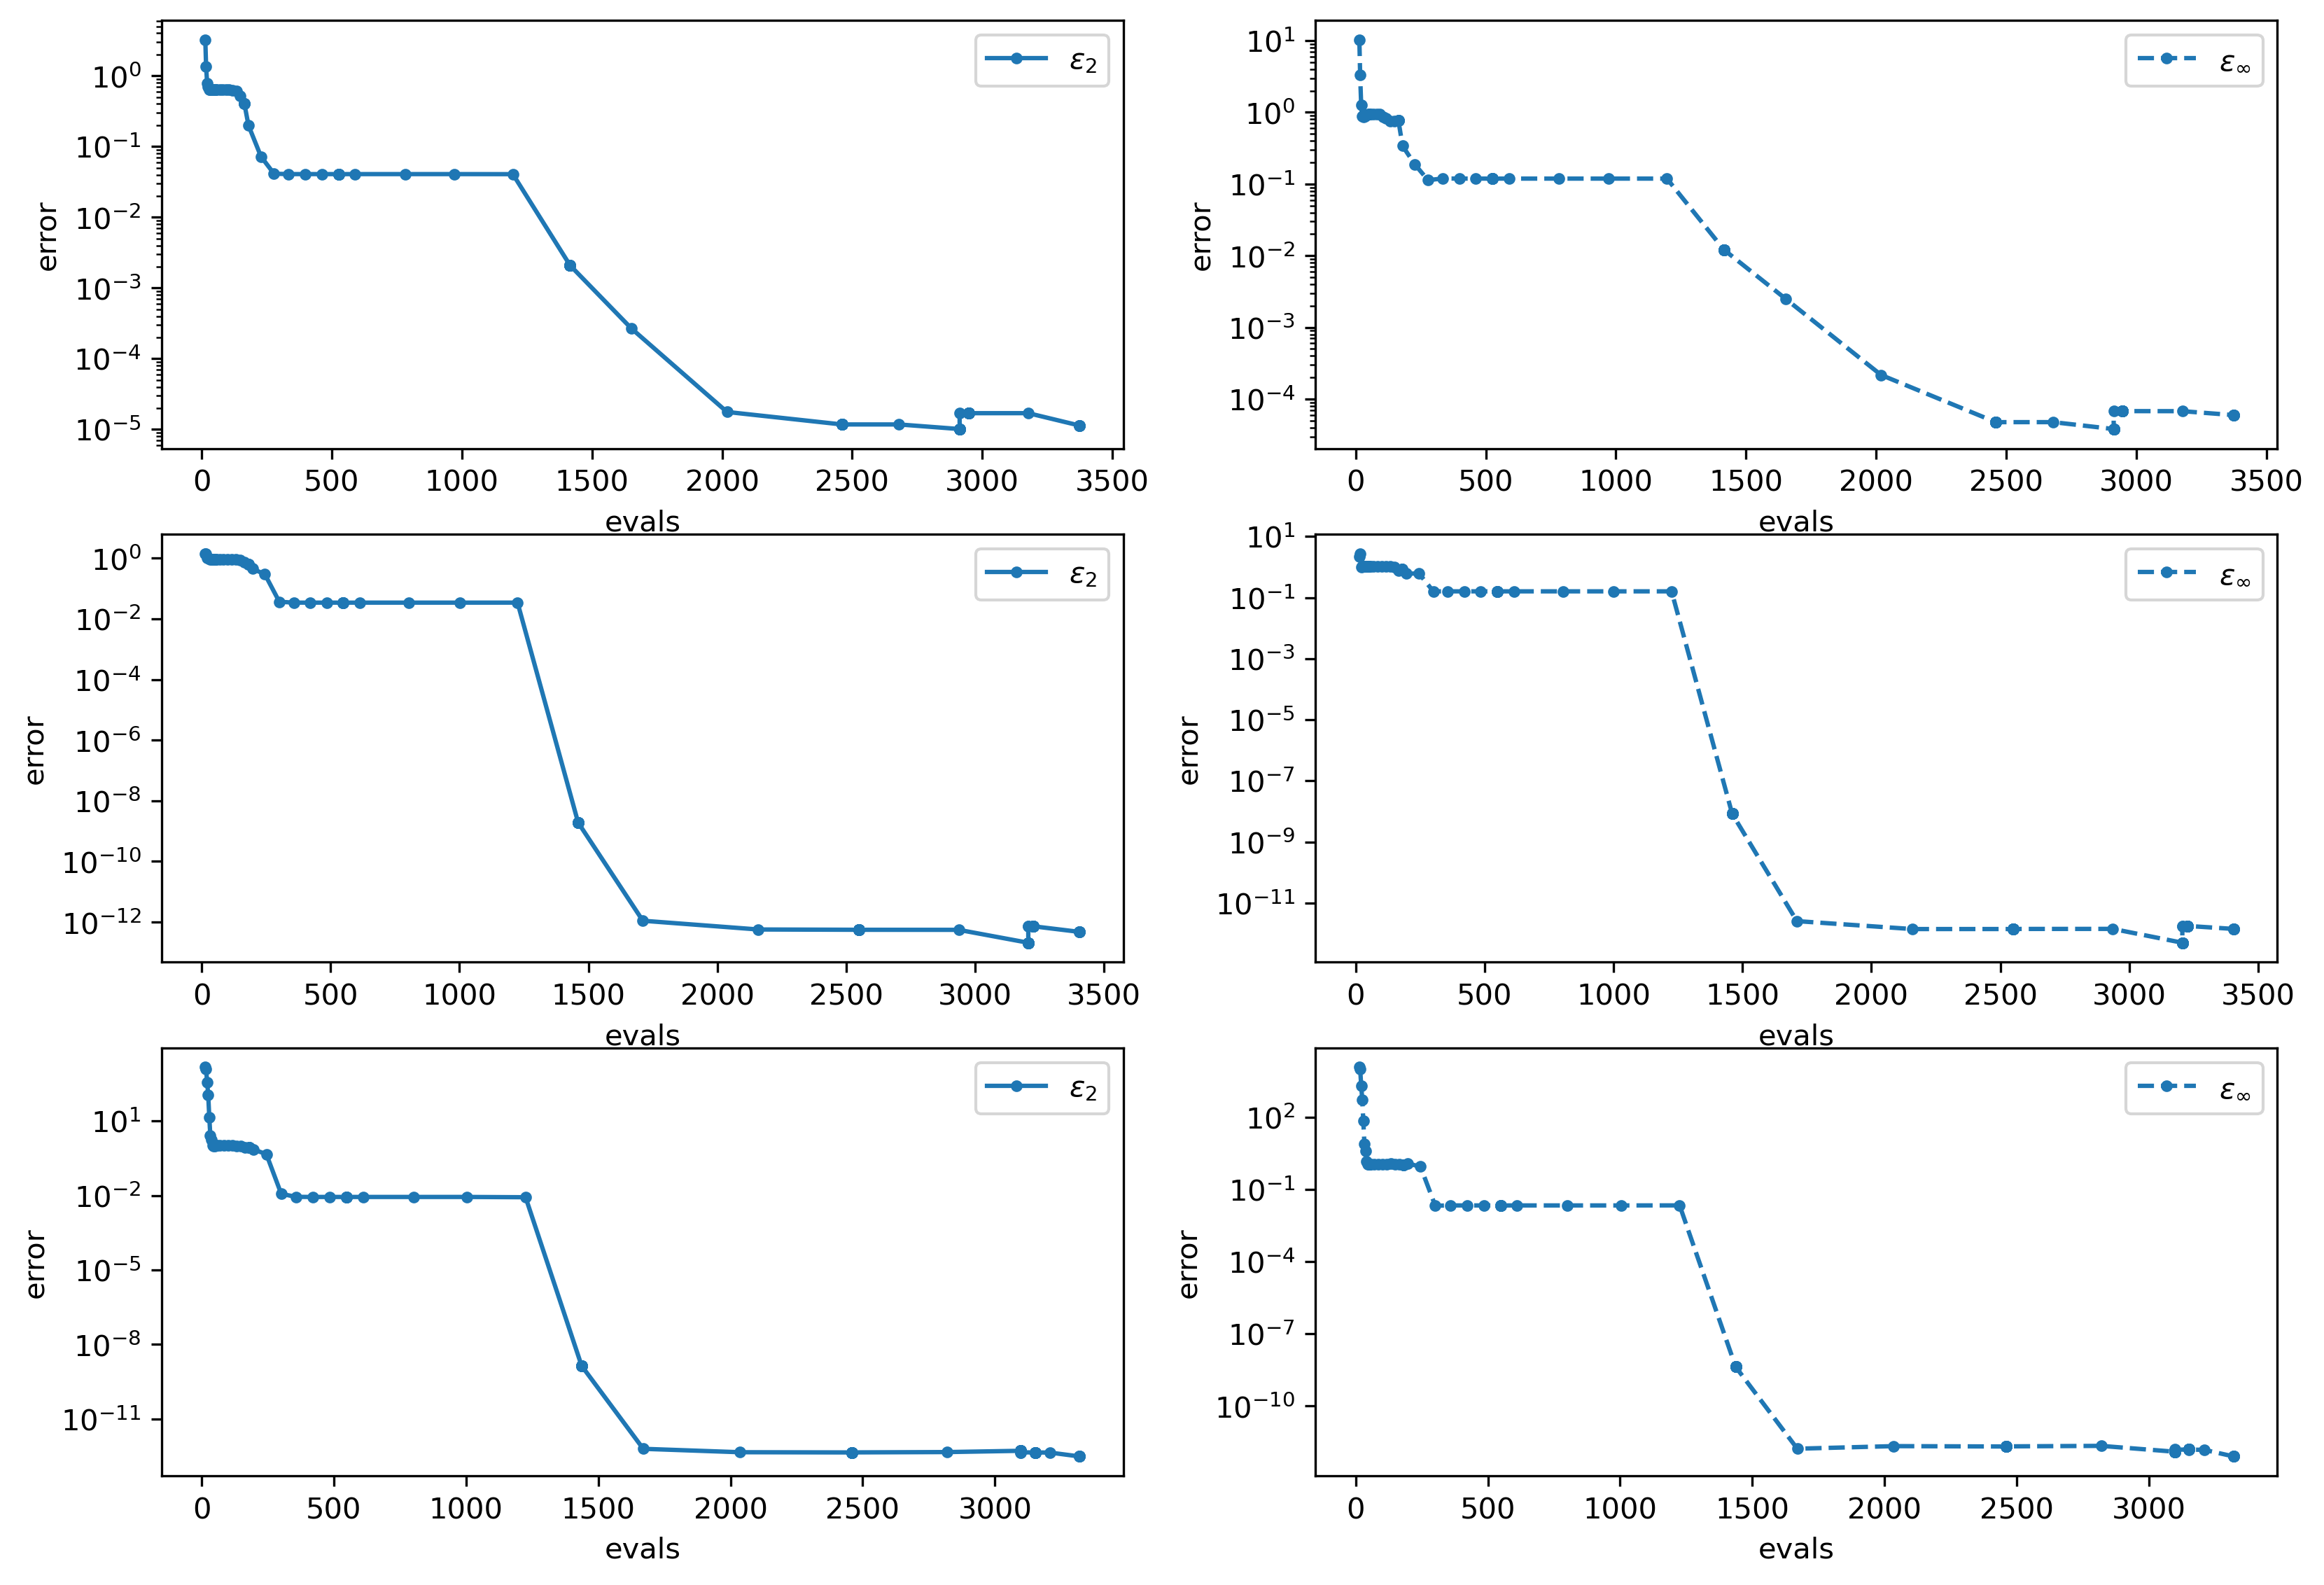

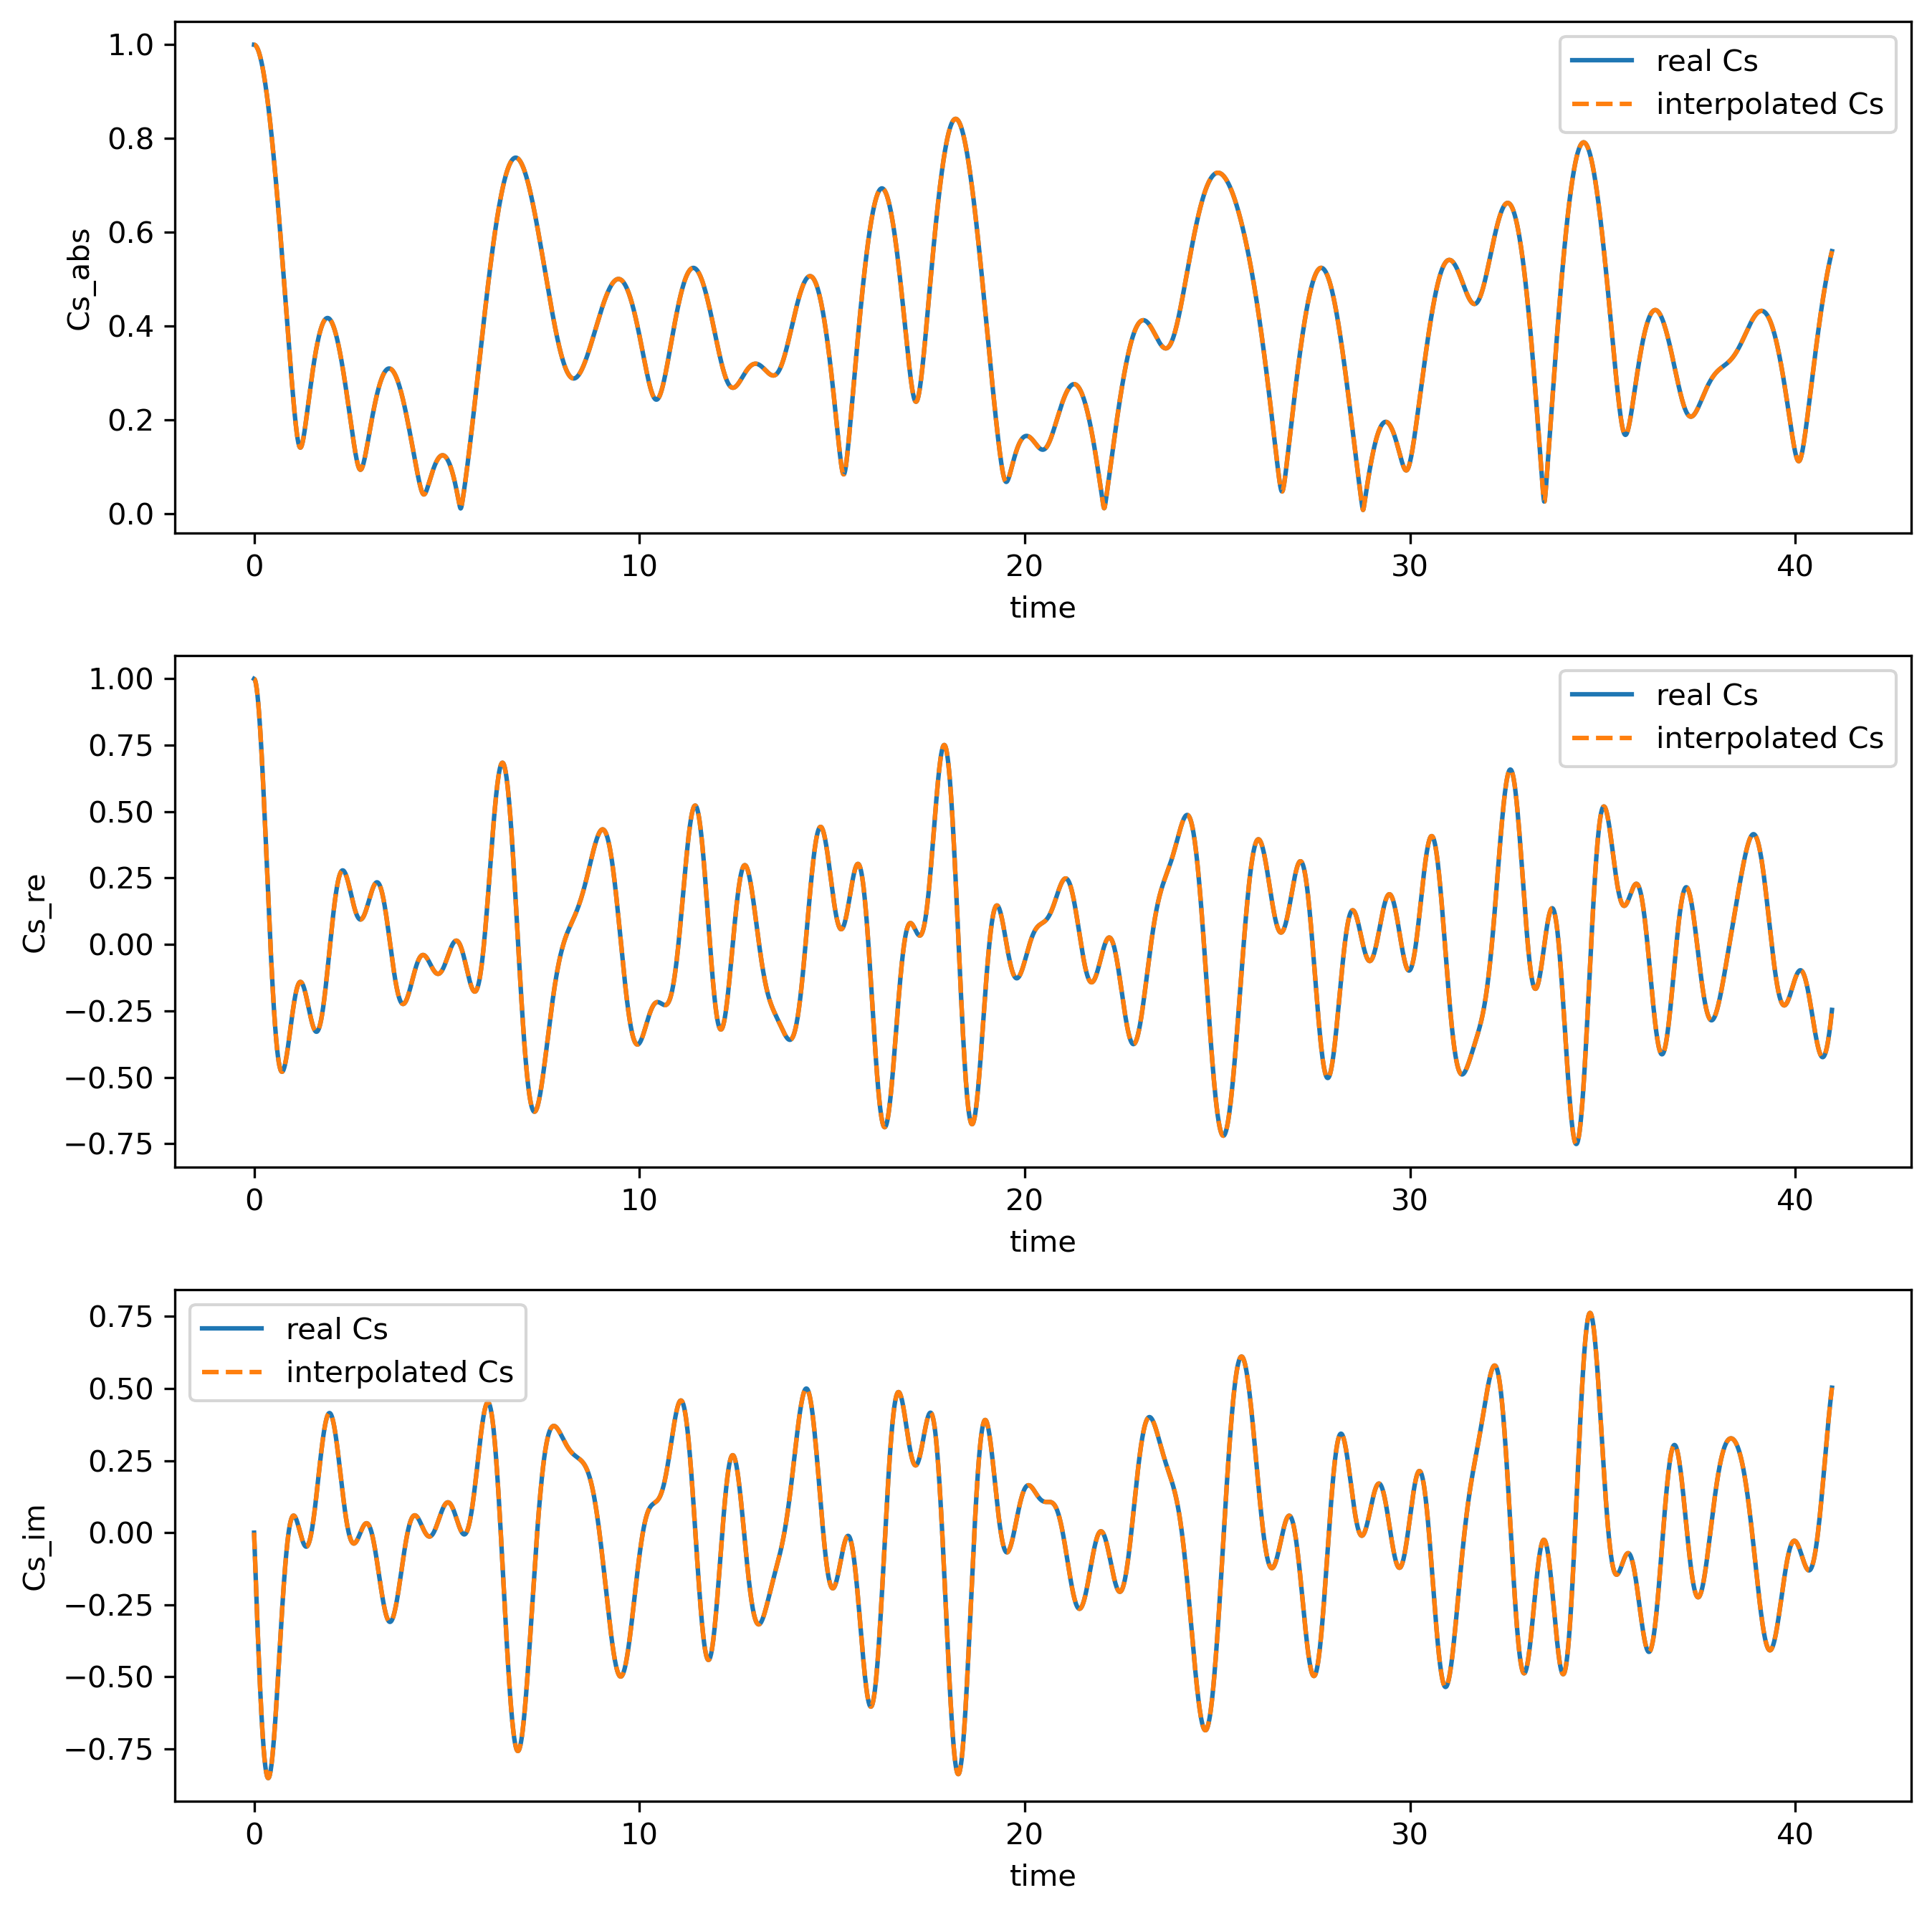

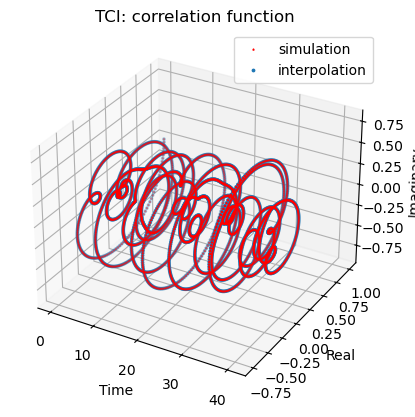

In [86]:
#print(type(Cs))
C = {}

C["Cs_abs"] = np.abs(Cs)
C["Cs_re"] = Cs.real
C["Cs_im"] = Cs.imag
key = []
for i in C:
    key.append(i)

print(key)
for i in range(3):
    print(C[key[i]])

fig1, axs1 = plt.subplots(nrows=3, ncols=2, figsize=(13,9), dpi=300)
fig2, axs2 = plt.subplots(nrows=3, figsize=(9,9), dpi=300)

func_plot = []

for i in range(3):
    func = TCI.function(lambda *x: C[key[i]].reshape((2,) * n)[*x])

    As, _, eval, err_2, err_max = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                    C[key[i]],      
                                    L=n,          # number of MPS tensors
                                    eps_or_chi=20, # bond dimension
                                    iters=4)       # number of back-and-forth sweeps


    axs1[i,0].plot(eval, np.array(err_2), '.-', label = r"$\epsilon_2$")
    axs1[i,1].plot(eval, err_max, '.--', label = r"$\epsilon_\infty$")
    axs1[i,0].set(xlabel="evals",ylabel="error",
            #xscale="log",
            yscale="log",
            #ylim=(1e-5, 1e0)
            )
    axs1[i,1].set(xlabel="evals",
            ylabel="error",
            #xscale="log",
            yscale="log",
            #ylim=(1e-2,1e2)
            )
    axs1[i,0].legend()
    axs1[i,1].legend()

    #plt.tight_layout()

    func_interp = np.squeeze(As[0]) #removes any singleton dimensions (dimensions of size 1).
    for A in As[1:]:
        func_interp = np.einsum('ia, ajb -> ijb', func_interp, A) #einstein summation
        func_interp = func_interp.reshape(-1, A.shape[-1])
    
    func_interp = np.squeeze(func_interp)
    func_plot.append(func_interp) 

    axs2[i].plot(np.arange(N)*dt, C[key[i]], '-', label = "real Cs")
    axs2[i].plot(np.arange(N)*dt, func_interp, '--', label="interpolated Cs")
    axs2[i].set(xlabel="time", ylabel=key[i])
    axs2[i].legend()
plt.tight_layout()
plt.show()

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(N)*dt,np.real(Cs),np.imag(Cs), s = 0.5, marker = '^', color = "red", label='simulation')
ax.scatter(np.arange(N)*dt,func_plot[1],func_plot[2], s = 3, marker = 'o', label = 'interpolation')
ax.set_title('TCI: correlation function')
ax.set_xlabel('Time')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.legend()
#plt.show()


### Errors vs evaluations($\chi$) for Cs.abs 

Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.


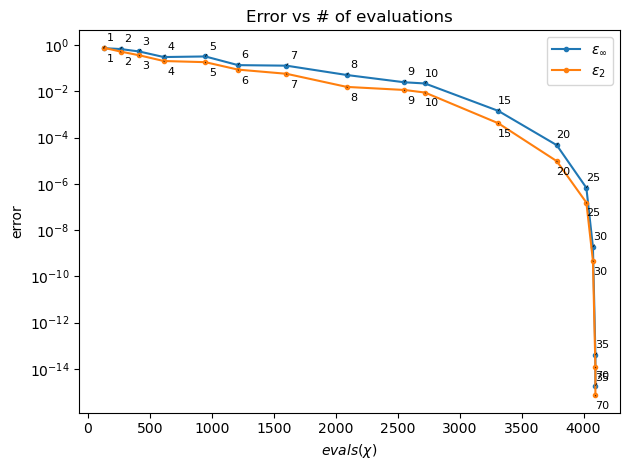

In [67]:
err_max = []
err_2 = []
evals = []

func = TCI.function(lambda *x: C["Cs_abs"].reshape((2,) * n)[*x])

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,40,5)])
chi_list.append(70)

for chi in chi_list:
    a = TCI.tensor_cross_errorvschi(func,         # function to be interpolated
                                    C["Cs_abs"],      
                                    L=n,          # number of MPS tensors
                                    eps_or_chi=chi, # bond dimension
                                    iters=4)       # number of back-and-forth sweeps
    err_max.append(a[0])
    err_2.append(a[1])
    evals.append(a[2])

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

### TCI FOR WHOLE CS

/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI_singlesite.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  Pi[il,s1,s2,jr] = val
/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI_singlesite.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  Pi[il,s1,s2,jr] = val


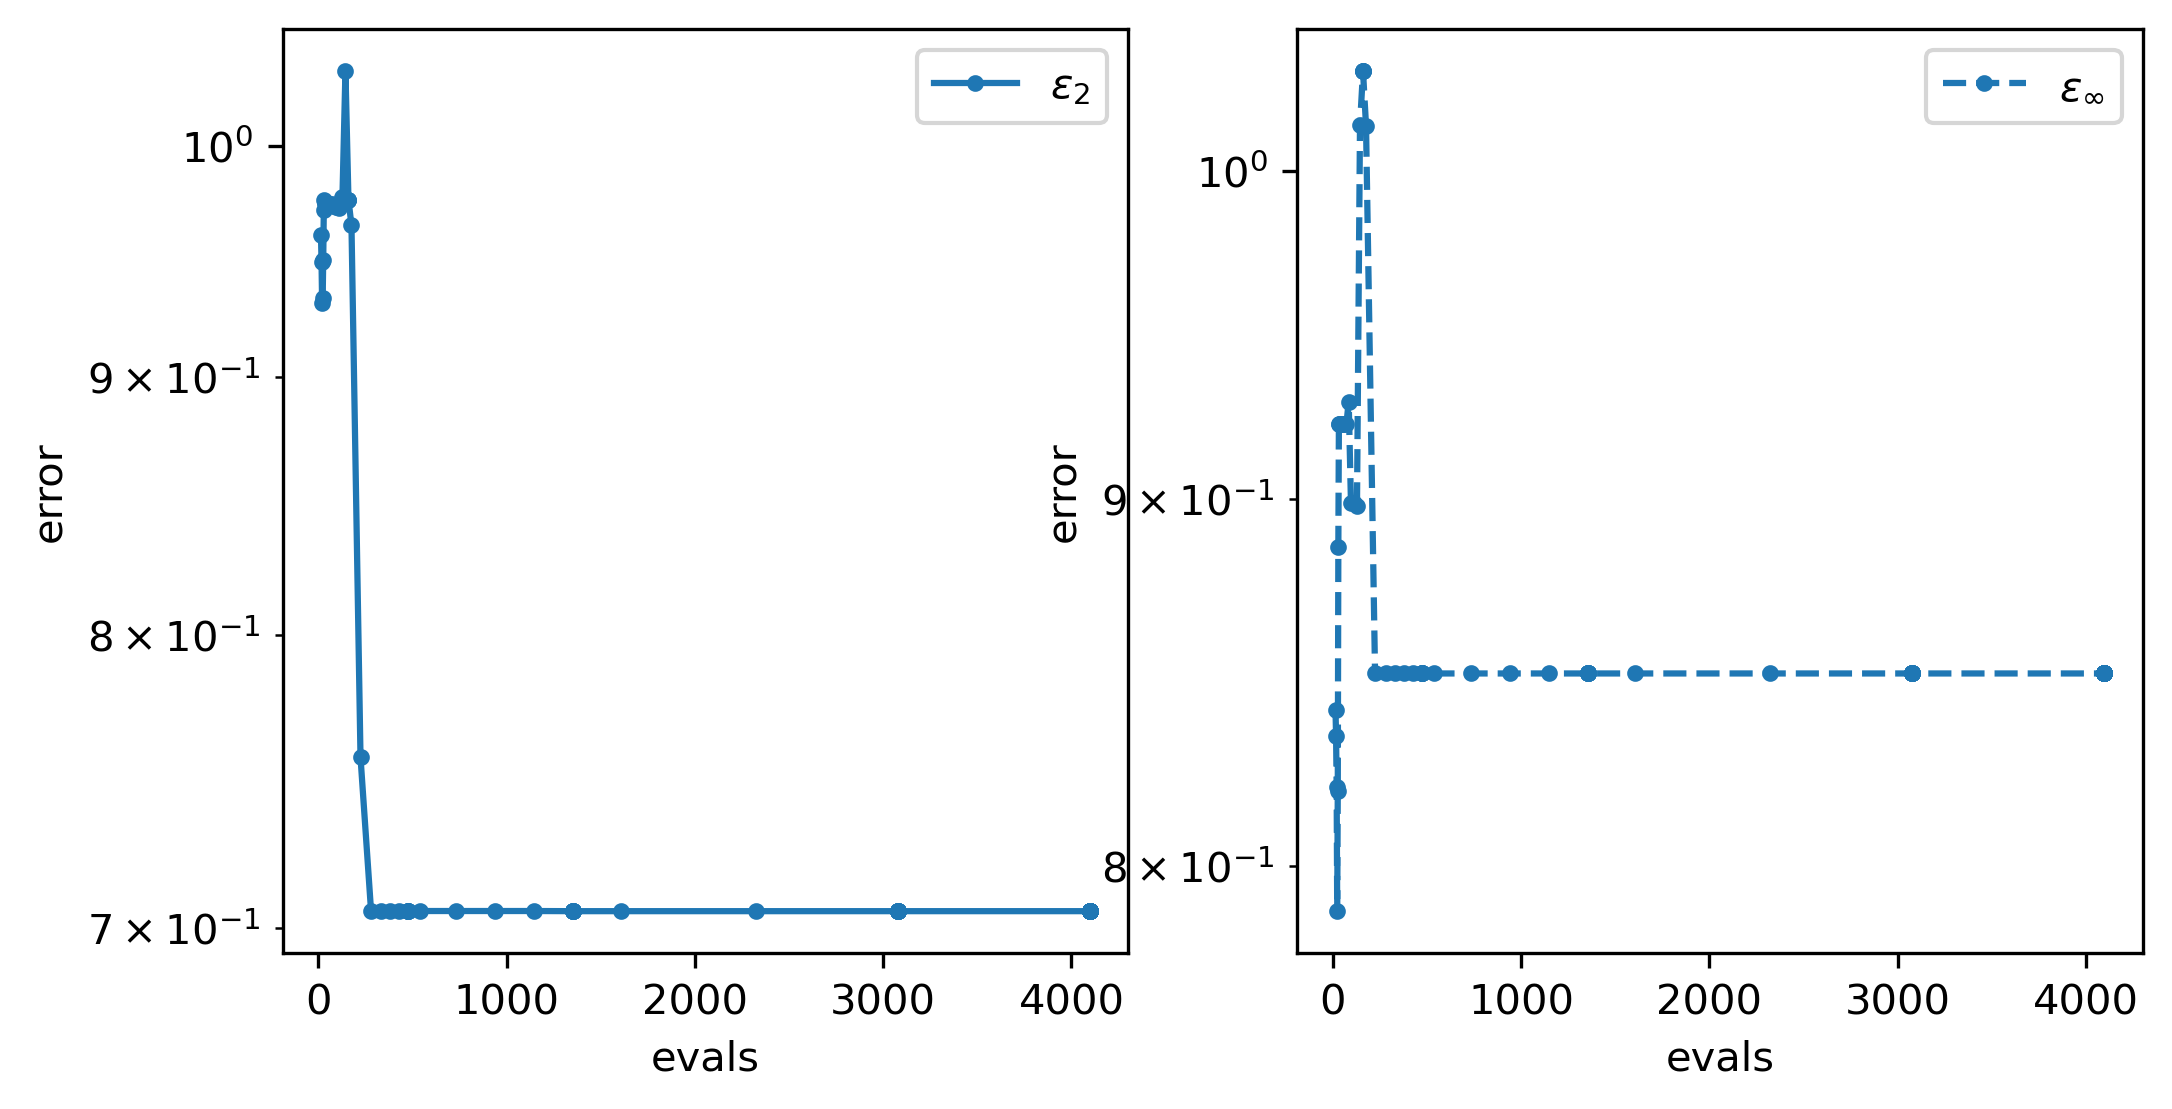

/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


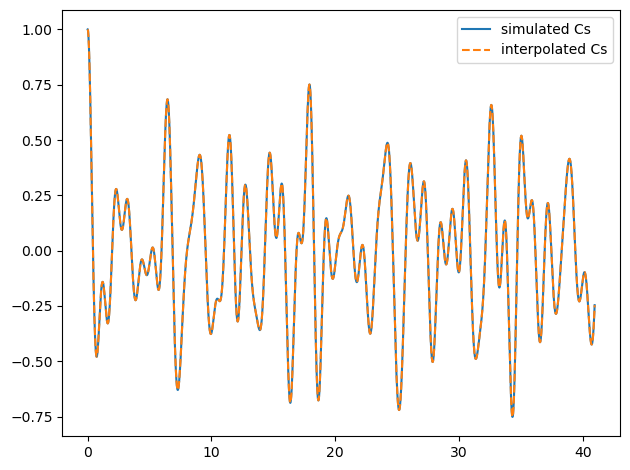

<Figure size 640x480 with 0 Axes>

In [59]:
func = TCI.function(lambda *x: Cs.reshape((2,) * n)[*x])

As, _, eval, err_2, err_max = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                Cs,      
                                L=n,          # number of MPS tensors
                                eps_or_chi=40, # bond dimension
                                iters=4)       # number of back-and-forth sweeps

fig, axs = plt.subplots(ncols=2, figsize=(8,4), dpi=300)

axs[0].plot(eval, np.array(err_2), '.-', label = r"$\epsilon_2$")
axs[1].plot(eval, err_max, '.--', label = r"$\epsilon_\infty$")
axs[0].set(xlabel="evals",ylabel="error",
        #xscale="log",
        yscale="log",
        #ylim=(1e-5, 1e0)
        )
axs[1].set(xlabel="evals",
        ylabel="error",
        #xscale="log",
        yscale="log",
        #ylim=(1e-2,1e2)
        )
axs[0].legend()
axs[1].legend()
plt.show()

func_interp = np.squeeze(As[0]) #removes any singleton dimensions (dimensions of size 1).
for A in As[1:]:
        func_interp = np.einsum('ia, ajb -> ijb', func_interp, A) #einstein summation
        func_interp = func_interp.reshape(-1, A.shape[-1])
    
func_interp = np.squeeze(func_interp)
ts = np.arange(N)*dt
plt.plot(np.arange(N)*dt, Cs, '-', label = "simulated Cs")
plt.plot(np.arange(N)*dt, func_interp, '--', label="interpolated Cs")
plt.legend()
plt.tight_layout()
plt.show()

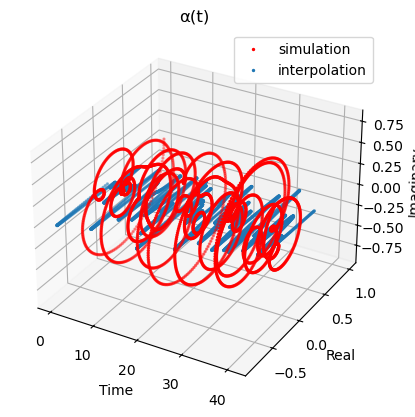

In [72]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,np.real(Cs),np.imag(Cs), s = 2, color = "red", label='simulation')
ax.scatter(ts,np.real(func_interp),np.imag(func_interp), s = 2, label = 'interpolation')
ax.set_title('α(t)')
ax.set_xlabel('Time')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.legend()
#plt.show()

<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_13425/4029221754.py:38: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation
/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI_singlesite.py:251: ComplexWarning: Casting complex values to real discards the imaginary part
  for jr in range(chir):
/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI_singlesite.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  for jr in range(chir):


Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.
Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.


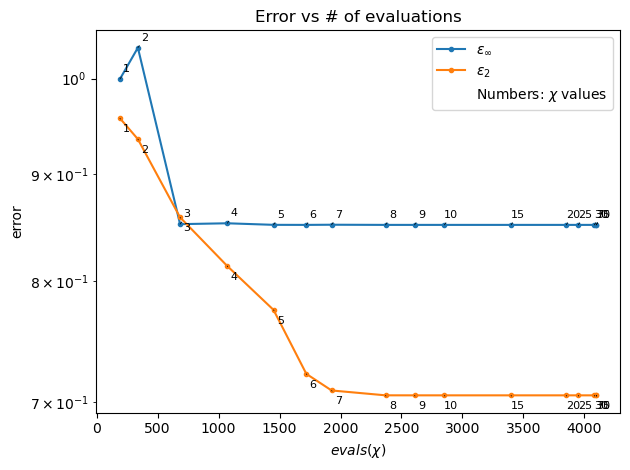

In [66]:
err_max = []
err_2 = []
evals = []

func = TCI.function(lambda *x: Cs.reshape((2,) * n)[*x])

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,40,5)])
chi_list.append(70)

for chi in chi_list:
    a = TCI.tensor_cross_errorvschi(func,         # function to be interpolated
                                    Cs,      
                                    L=n,          # number of MPS tensors
                                    eps_or_chi=chi, # bond dimension
                                    iters=4)       # number of back-and-forth sweeps
    err_max.append(a[0])
    err_2.append(a[1])
    evals.append(a[2])

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

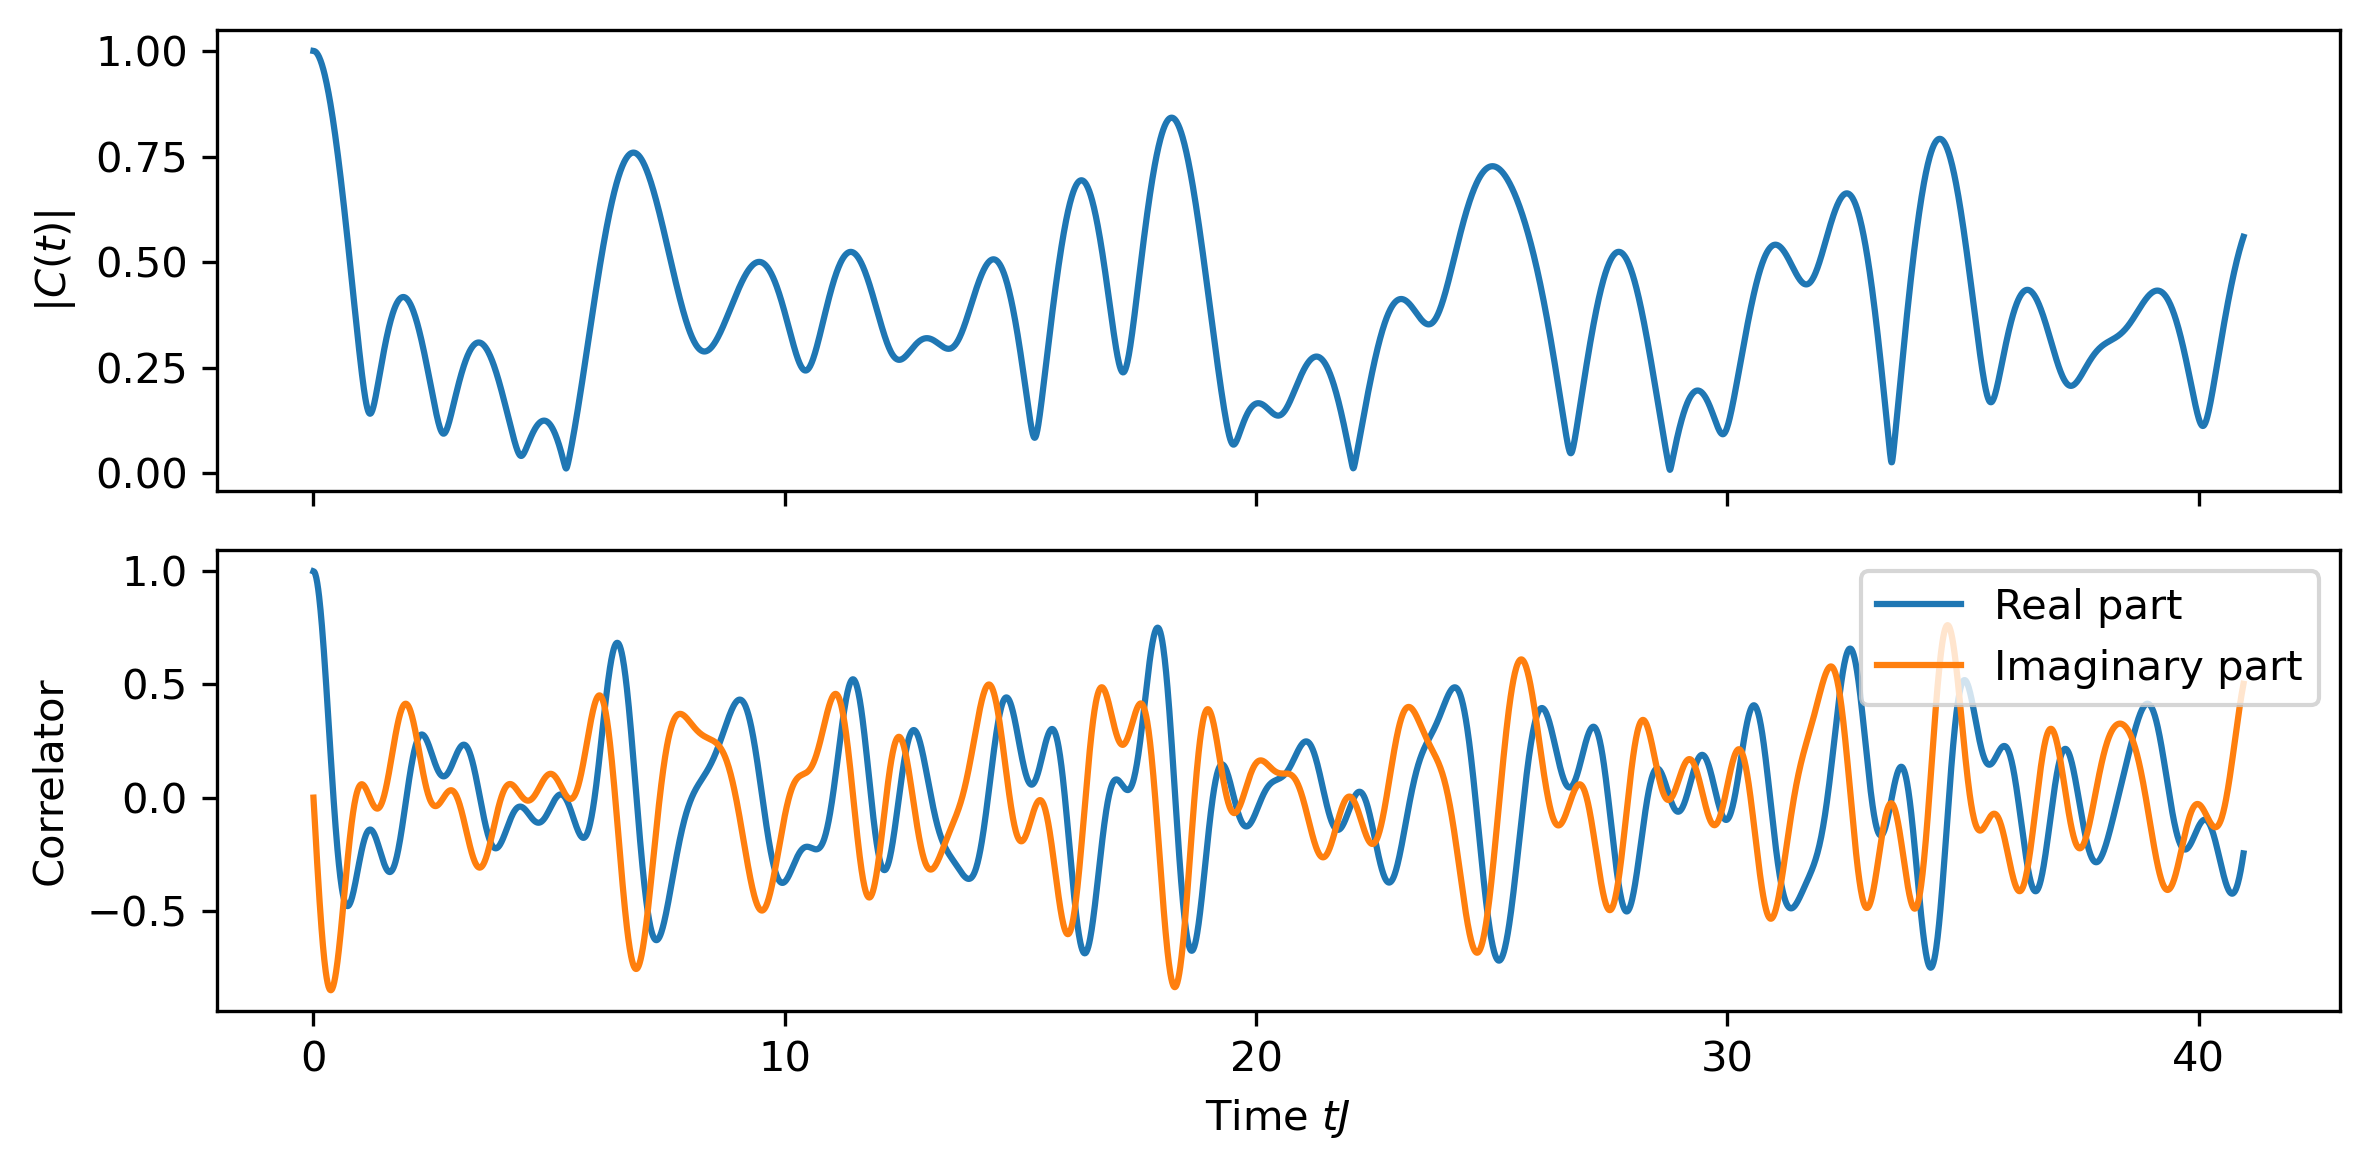

In [ ]:
# plot real, imaginary part and absolute value
fig, axs = plt.subplots(nrows=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(np.arange(N)*dt, np.abs(Cs))
axs[0].set(ylabel=r'$|C(t)|$')
axs[1].plot(np.arange(N)*dt, Cs.real, label='Real part')
axs[1].plot(np.arange(N)*dt, Cs.imag, label='Imaginary part')
axs[1].set(xlabel=r'Time $tJ$',
           ylabel=r'Correlator')
axs[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Fourier transform the time-domain with windowing function cos(pi/2 * t/T)**nw
def timeFT(Ct, t_list, nw=4):
    """
    full complex data as input. 
    data only for positive time.
    """
    
    n = len(t_list)
    Wfunlist = [np.cos(np.pi*t_list[t]/(2*t_list[-1]))**nw  for t in range(n)]
    
    input_list = Wfunlist[:] * (np.array(Ct[:]))
    FTresult = np.fft.fft(input_list)
    
    freq = 2 * np.pi * np.fft.fftfreq(n, t_list[1]-t_list[0])
    freq = np.fft.fftshift(freq)
    FTresult = np.fft.fftshift(FTresult)
    
    return freq, FTresult

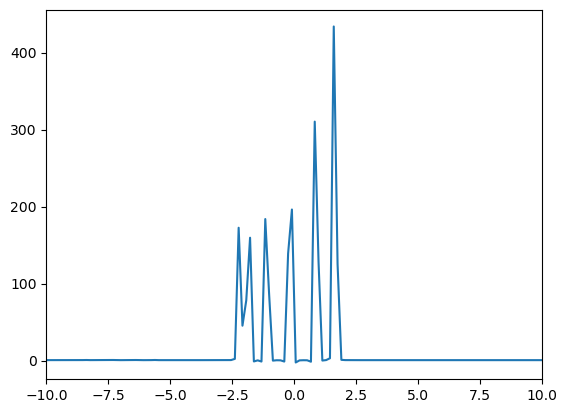

In [11]:
freq, FTresult = timeFT(Ct=Cs, t_list=np.arange(N)*dt, nw=3)
plt.plot(freq-E0+E1, np.real(FTresult))
plt.xlim(-10,10)
plt.show()